In [1]:
import os 
import pandas as pd
import numpy as np
import tqdm
import matplotlib.pyplot as plt
np.random.seed  = 0

In [2]:
df = pd.read_csv(r"C:\Felix\weather_dataset\Student Labeled\student_labelled.csv")
df["Weather"] = df.Weather.replace({"snowfall":"Snowy","rainfall":"Rainy","clear":"Clear","cloudy":"Cloudy"})
df.loc[df.Cover == "snow","Weather"] = "Snowy"
df.loc[df.Cover == "rain","Weather"] = "Rainy"
df = df.loc[(df.Weather != 'unobservable') & (df.Lighting_Condition == "day")] 
df.value_counts("Weather")

df["path"] = [os.path.join(r"C:\Felix\weather_dataset\Student Labeled\images_renamed",str(i))+".jpeg" for i in df.id]
df = df.loc[df.path.apply(os.path.exists)]
df["origin"] = "Student_samples"

In [3]:
paths = [
    (r"C:\Felix\weather_dataset\SSLAD-2D\Clear",'Clear',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\SSLAD-2D\Overcast",'Cloudy',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\SSLAD-2D\Rainy",'Rainy',"SSLAD-2D"),
    (r"C:\Felix\weather_dataset\Raidar\test","Rainy","Raidar"),
    (r"C:\Felix\weather_dataset\Raidar\train","Rainy","Raidar"),
    (r"C:\Felix\weather_dataset\mapilar snow\images","Snowy","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\Foggy Cityscapes","Foggy","Foggy Cityscapes"),
    (r"C:\Felix\weather_dataset\Duckduckgo\fog","Foggy","Duckduckgo"),
    (r"C:\Felix\weather_dataset\Duckduckgo\snow","Snowy","Duckduckgo"),
    (r"C:\Felix\weather_dataset\DAWN\Rain","Rainy","Dawn"),
    (r"C:\Felix\weather_dataset\DAWN\Snow","Snowy","Dawn"),
    (r"C:\Felix\weather_dataset\DAWN\Fog","Foggy","Dawn"),
    (r"C:\Felix\weather_dataset\rain","Rainy","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\fog","Foggy","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\clear","Clear","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\mapilar snow\images2","Snowy","Yujun-Mapilarly"),
    (r"C:\Felix\weather_dataset\cloudy","Cloudy","Yujun-Mapilarly"),
]

erg = []

for folder, weather, origin in paths:

    for img in os.listdir(folder):
        if ".jpg" in img or ".jpeg" in img:
            erg.append((os.path.join(folder,img),weather,origin))   

new = pd.DataFrame(erg,columns=["path","weather","origin"])
df = pd.concat([df[["path","Weather","origin"]].rename(columns={"Weather":"weather"}),new])
df.index = range(len(df))

In [4]:
# import tensorflow as tf
# with tf.device('Gpu:0'):
#     ds = general_preprocessing.get_ds(df,6)

#     model = get_models.get_pano()
#     preds = model.predict(ds,verbose=1) > .5

In [5]:
# tf.keras.backend.clear_session()
# model = get_models.get_night_day()
# night_preds = model.predict(ds,verbose=1) > .5
# np.save("../weather_dataset/night_pred.npy",night_preds)
# np.save("../weather_dataset/pano_pred.npy",preds)

In [6]:
# out = r"C:\Felix\weather_dataset\night"
# import tqdm
# night = df.loc[night_preds]
# for i in tqdm.tqdm(range(len(night))):
#     row = night.iloc[i]
#     img = plt.imread(row.loc["path"])
#     plt.imshow(img)
#     plt.savefig(os.path.join(out,f"{i}_{row['origin']}")+".jpg")
#     plt.close()

In [7]:
night_preds = np.load("../../weather_dataset/night_pred.npy")
pano_preds = np.load("../../weather_dataset/pano_pred.npy")
new_student_labeled = ((df.origin =="Yujun-Mapilarly") & (df.weather =="Rainy")).values.argmax()

old = df.loc[:new_student_labeled]
old = old.loc[(pano_preds) | (night_preds)].index
df = df.drop(index=old)
df.index = range(len(df))

In [8]:
df.value_counts(["origin","weather"])

origin            weather
Raidar            Rainy      18212
SSLAD-2D          Clear       9402
Yujun-Mapilarly   Cloudy      6987
SSLAD-2D          Cloudy      4453
Yujun-Mapilarly   Clear       4281
                  Snowy       3607
SSLAD-2D          Rainy       2107
Yujun-Mapilarly   Rainy       1486
Duckduckgo        Snowy       1080
                  Foggy       1008
Student_samples   Clear        943
Dawn              Foggy        294
Student_samples   Cloudy       264
Dawn              Snowy        203
                  Rainy        195
Foggy Cityscapes  Foggy        101
Yujun-Mapilarly   Foggy         66
Student_samples   Snowy         29
                  Rainy         10
dtype: int64

In [9]:
gold_standard = ["Student_samples","Yujun-Mapilarly","Dawn","Foggy Cityscapes"]
df["gold_standard"] = df.origin.apply(lambda x: x in gold_standard)
gold = df.loc[df.origin.apply(lambda x: x in gold_standard)]
gold.value_counts(["weather"])

weather
Cloudy     7251
Clear      5224
Snowy      3839
Rainy      1691
Foggy       461
dtype: int64

Clear, Cloudy are enough to be spread all over train, val & test. Snowy will be a bit supported in training as well as Rainy & Foggy.

Cloudy 

In [10]:
split = 7251 // 10

pool = df.loc[df.gold_standard & (df.weather == "Cloudy")].index.tolist()
np.random.shuffle(pool)

def assign_split(pool,split,df):
    val,test,train = pool[:split],pool[split:split+split],pool[split+split:]

    df.loc[val,"ds_type"] = "val"
    df.loc[test,"ds_type"] = "test"
    df.loc[train,"ds_type"] = "train"

assign_split(pool,split,df)

Clear

In [11]:
split = 5224 // 10

pool = df.loc[df.gold_standard & (df.weather == "Clear")].index.tolist()
np.random.shuffle(pool)

def assign_split(pool,split,df):
    val,test,train = pool[:split],pool[split:split+split],pool[split+split:]

    df.loc[val,"ds_type"] = "val"
    df.loc[test,"ds_type"] = "test"
    df.loc[train,"ds_type"] = "train"

assign_split(pool,split,df)

Snowy

In [12]:
split = 4800//10

pool = df.loc[df.gold_standard & (df.weather == "Snowy")].index.tolist()
np.random.shuffle(pool)
print(len(pool))
def assign_split(pool,split,df):
    val,test,train = pool[:split],pool[split:split+split],pool[split+split:]

    df.loc[val,"ds_type"] = "val"
    df.loc[test,"ds_type"] = "test"
    df.loc[train,"ds_type"] = "train"

assign_split(pool,split,df)

df.loc[(df.origin == "Duckduckgo") & (df.weather == "Snowy"),"ds_type"] = "train"
df.query("weather == 'Snowy'").ds_type.value_counts(normalize = True)

3839


train    0.804838
test     0.097581
val      0.097581
Name: ds_type, dtype: float64

Rainy

In [13]:
raidar_train= df.loc[(df.origin == "Raidar") & (df.path.str.contains("train"))].index.tolist()
raidar_test= df.loc[(df.origin == "Raidar") & (df.path.str.contains("test"))].index.tolist()
print(len(raidar_test),len(raidar_train))

gold_standard = df.loc[(df.gold_standard) & (df.weather == "Rainy")].sample(frac = 1,random_state= 0).index.tolist()
# 600 fist to train
print(len(gold_standard))
df.loc[gold_standard[:600],"ds_type"]= "train"
val_test = gold_standard[600:]
np.random.shuffle(raidar_train)
np.random.shuffle(raidar_test)

df.loc[raidar_train[:6000],"ds_type"]= "train"
val_test.extend(raidar_test[:500])
np.random.shuffle(val_test)
df.loc[val_test[:len(val_test)//2],"ds_type"] = "val"
df.loc[val_test[len(val_test)//2:],"ds_type"] = "test"
df.query("weather == 'Rainy'").ds_type.value_counts(normalize = True)


3642 14570
1691


train    0.805762
test     0.097180
val      0.097058
Name: ds_type, dtype: float64

In [14]:
split = 1500//10

pool = df.loc[df.gold_standard & (df.weather == "Foggy")].index.tolist()
np.random.shuffle(pool)

def assign_split(pool,split,df):
    val,test,train = pool[:split],pool[split:split+split],pool[split+split:]

    df.loc[val,"ds_type"] = "val"
    df.loc[test,"ds_type"] = "test"
    df.loc[train,"ds_type"] = "train"

assign_split(pool,split,df)

df.loc[(df.origin == "Duckduckgo") & (df.weather == "Foggy"),"ds_type"] = "train"
df.query("weather == 'Foggy'").ds_type.value_counts(normalize = True)

train    0.795779
test     0.102110
val      0.102110
Name: ds_type, dtype: float64

In [15]:
df = df.loc[df.ds_type.notna()]

In [16]:
df.query("ds_type == 'val'").value_counts(["weather","origin"])


weather  origin          
Cloudy   Yujun-Mapilarly     704
Rainy    Yujun-Mapilarly     480
Snowy    Yujun-Mapilarly     446
Clear    Yujun-Mapilarly     417
Rainy    Raidar              252
Clear    Student_samples     105
Foggy    Dawn                103
Rainy    Dawn                 62
Snowy    Dawn                 29
Foggy    Foggy Cityscapes     25
         Yujun-Mapilarly      22
Cloudy   Student_samples      21
Snowy    Student_samples       5
Rainy    Student_samples       1
dtype: int64

In [17]:
df.query("ds_type == 'test'").value_counts(["weather","origin"])


weather  origin          
Cloudy   Yujun-Mapilarly     698
Rainy    Yujun-Mapilarly     477
Snowy    Yujun-Mapilarly     443
Clear    Yujun-Mapilarly     420
Rainy    Raidar              248
Clear    Student_samples     102
Foggy    Dawn                 97
Rainy    Dawn                 69
Snowy    Dawn                 34
Foggy    Foggy Cityscapes     32
Cloudy   Student_samples      27
Foggy    Yujun-Mapilarly      21
Snowy    Student_samples       3
Rainy    Student_samples       2
dtype: int64

In [18]:
df.query("ds_type == 'train'").value_counts(["weather","origin"])

weather  origin          
Rainy    Raidar              6000
Cloudy   Yujun-Mapilarly     5585
Clear    Yujun-Mapilarly     3444
Snowy    Yujun-Mapilarly     2718
         Duckduckgo          1080
Foggy    Duckduckgo          1008
Clear    Student_samples      736
Rainy    Yujun-Mapilarly      529
Cloudy   Student_samples      216
Snowy    Dawn                 140
Foggy    Dawn                  94
Rainy    Dawn                  64
Foggy    Foggy Cityscapes      44
         Yujun-Mapilarly       23
Snowy    Student_samples       21
Rainy    Student_samples        7
dtype: int64

In [19]:
df.query("ds_type == 'train'").value_counts(["weather"],normalize=True)


weather
Rainy      0.304021
Cloudy     0.267216
Clear      0.192547
Snowy      0.182367
Foggy      0.053849
dtype: float64

In [20]:
df.query("ds_type == 'val'").value_counts(["weather"],normalize=True)


weather
Rainy      0.297530
Cloudy     0.271332
Clear      0.195359
Snowy      0.179641
Foggy      0.056138
dtype: float64

In [21]:
df.query("ds_type == 'test'").value_counts(["weather"],normalize=True)

weather
Rainy      0.297793
Cloudy     0.271231
Clear      0.195286
Snowy      0.179574
Foggy      0.056117
dtype: float64

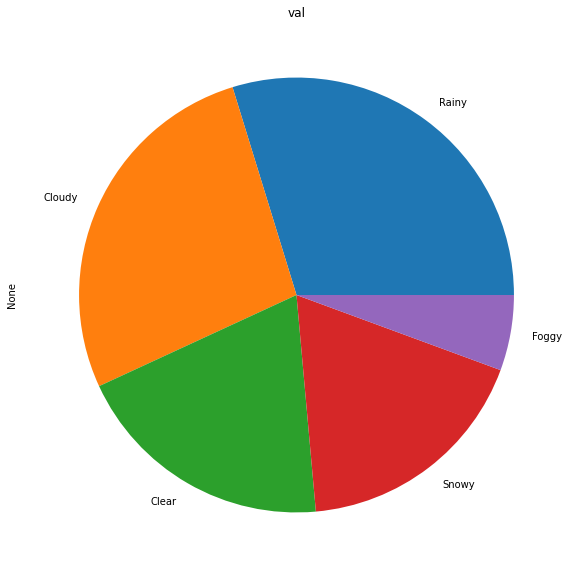

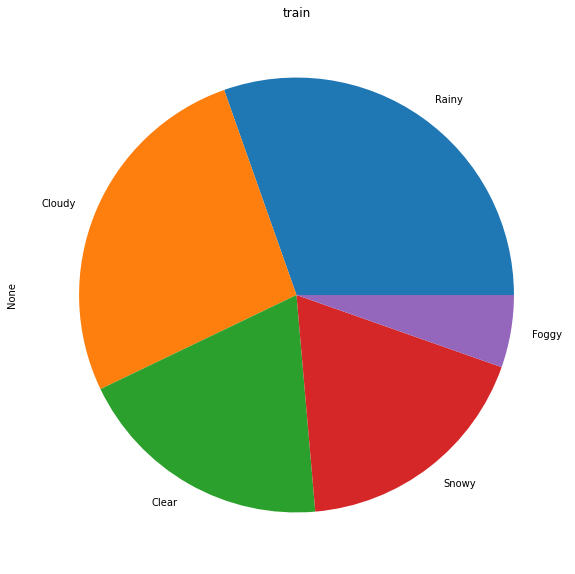

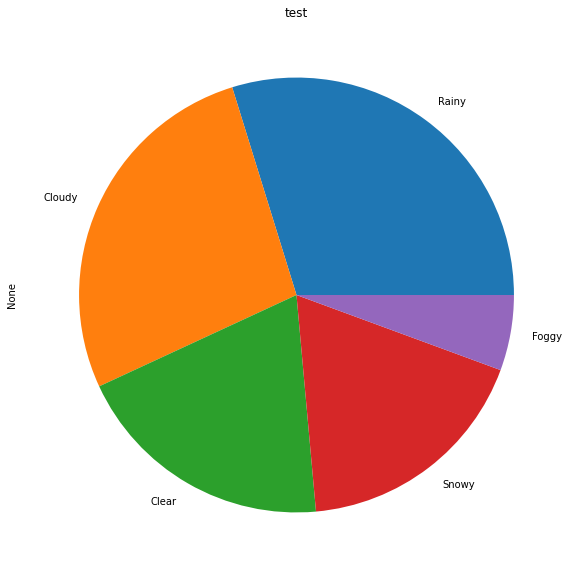

In [22]:
for t in df.ds_type.unique():
    plt.figure(figsize=(10,10))
    l = df.query('ds_type == @t')
    l.value_counts("weather").plot.pie()
    plt.title(t)
    plt.show()

In [32]:
df["id"] = df.path.apply(lambda x:hashlib.sha224(str.encode(x)).hexdigest()+".jpg")

out = r"C:\Felix\weather_data_set_ready_to_train"
new_paths = []
for i in tqdm.tqdm(range(len(df))):
    row = df.iloc[i]
    new_paths.append(os.path.join(out,row.ds_type,row.weather,row.id))

100%|██████████| 27054/27054 [00:02<00:00, 9964.51it/s] 


In [40]:
old_paths = []
for i in ["train","val","test"]:
    for w in df.weather.unique():
        di = os.path.join(out,i,w)
        for p in os.listdir(di):
            old_paths.append(os.path.join(di,p))

In [41]:
to_del = set(old_paths).difference(new_paths)
len(to_del)

0

In [38]:
to_add = set(new_paths).difference(old_paths)
len(to_add)

14737

In [39]:
for p in tqdm.tqdm(to_del):
    os.remove(p)

100%|██████████| 9164/9164 [00:01<00:00, 5419.24it/s]


In [44]:
import hashlib
import tqdm
import cv2

for i in tqdm.tqdm(range(len(df))):
    row= df.iloc[i]
    new_path = os.path.join(out,row.ds_type,row.weather,row.id)
    if new_path in to_add:

        img = cv2.imread(row.path)
        if img.shape[0] > 400 or img.shape[1] > 400:
            img = cv2.resize(img, [400,400], interpolation= cv2.INTER_LINEAR)
        cv2.imwrite(new_path,img)

100%|██████████| 27054/27054 [07:07<00:00, 63.21it/s]  


In [42]:
df.reset_index().to_feather(os.path.join(out,"df.feather"))

In [43]:
df.path.duplicated().any()

False

In [45]:
df.value_counts("ds_type")

ds_type
train    21709
test      2673
val       2672
dtype: int64